# Recommendation System - Movie Recommendation
## This notebook outlines the concepts involved in building a Complete Recommendation System for recommending Movies to users
## Movie Recommender System - A very very very simple Clone of Netflix

### Import the libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
movies = pd.read_csv("ml-20m/movies.csv")
ratings = pd.read_csv("ml-20m/ratings.csv")
tags = pd.read_csv("ml-20m/tags.csv")

In [4]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
tags.head(5)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [ ]:
unique_movie_ids = ratings['movieId'].unique()

print("Unique movieIds:", ratings['movieId'].nunique())
print("Unique userIds:", ratings['userId'].nunique())

Unique movieIds: 26744
Unique userIds: 138493


# 1. Content Filtering

### Data Preparation
Prepare data for Metadata from merging movies and tags

In [8]:
# Aggregate tags by movieId, converting values to strings and filling missing values
movie_tags = tags.groupby('movieId', as_index=False).agg({
    'tag': lambda x: " ".join(x.fillna('').astype(str))
})

# Merge movies and aggregated tags, and create metadata by combining title and tags
movies_metadata = movies.merge(movie_tags, on='movieId', how='left')
movies_metadata['metadata'] = movies_metadata['title'] + " " + movies_metadata['tag'].fillna('')

print("Movies metadata sample:\n", movies_metadata[['movieId', 'title', 'metadata']].head())

Movies metadata sample:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                            metadata  
0  Toy Story (1995) Watched computer animation Di...  
1  Jumanji (1995) time travel adapted from:book b...  
2  Grumpier Old Men (1995) old people that is act...  
3  Waiting to Exhale (1995) chick flick revenge c...  
4  Father of the Bride Part II (1995) Diane Keato...  


## TF-IDF Vectorizer on Metadata

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
# Build TF-IDF matrix from metadata
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_metadata['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_metadata.index.tolist())
print(tfidf_df.shape)

(27278, 38243)


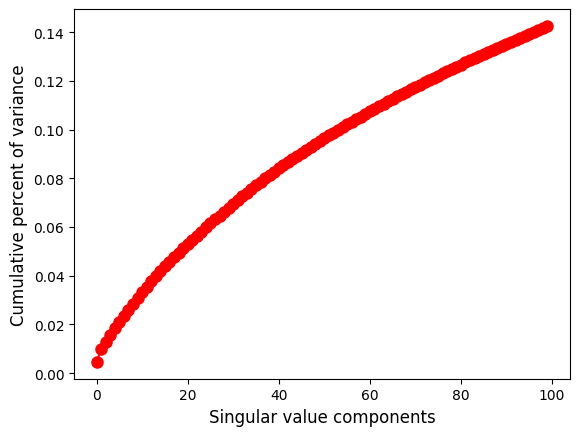

In [11]:
svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [12]:
content_sim = cosine_similarity(latent_matrix, latent_matrix)

In [13]:
def content_recommendations(movie_title, top_n=10):
    # Find the movie index for the given title
    idx = movies_metadata[movies_metadata['title'].str.contains(movie_title, case=False, regex=False)].index[0]
    sim_scores = list(enumerate(content_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the movie itself
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies_metadata[['movieId','title']].iloc[movie_indices]

In [14]:
# Test content recommender:
print("Content recommendations for 'Toy Story':")
print(content_recommendations("Toy Story", top_n=10))

Content recommendations for 'Toy Story':
       movieId                  title
3027      3114     Toy Story 2 (1999)
11614    50872     Ratatouille (2007)
6271      6377    Finding Nemo (2003)
5121      5218         Ice Age (2002)
2270      2355   Bug's Life, A (1998)
13767    68954              Up (2009)
4790      4886  Monsters, Inc. (2001)
7761      8360         Shrek 2 (2004)
15401    78499     Toy Story 3 (2010)
4211      4306           Shrek (2001)


## 2. Collaborative Filtering

In [15]:
# First set index on filtered_movies
filtered_movies = movies_metadata[movies_metadata['movieId'].isin(unique_movie_ids)]
filtered_movies = filtered_movies.set_index('movieId')
common_movie_ids = set(movies_metadata['movieId']).intersection(set(ratings['movieId'].unique()))

In [16]:
ratings_filtered = ratings[ratings['movieId'].isin(common_movie_ids)]
# Find movie IDs that exist in both datasets
valid_movie_ids = [mid for mid in unique_movie_ids if mid in filtered_movies.index]

In [17]:
# Create mappers and sparse matrix using only valid movie IDs
movie_mapper = {mid: i for i, mid in enumerate(valid_movie_ids)}
user_mapper = {uid: i for i, uid in enumerate(ratings_filtered['userId'].unique())}

In [18]:
# Filter ratings to only include valid movie IDs
ratings_valid = ratings_filtered[ratings_filtered['movieId'].isin(valid_movie_ids)]

row_indices = ratings_valid['movieId'].map(movie_mapper)
col_indices = ratings_valid['userId'].map(user_mapper)
data = ratings_valid['rating'].values

In [19]:
from scipy.sparse import coo_matrix
user_movies_data = coo_matrix((data, (row_indices, col_indices)),
                             shape=(len(movie_mapper), len(user_mapper)))

print("Sparse matrix shape:", user_movies_data.shape)

Sparse matrix shape: (26744, 138493)


In [20]:
# Now create the movie titles list
movie_titles = [filtered_movies.loc[mid, 'title'] for mid in valid_movie_ids]

In [21]:
# Create SVD latent matrix
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movie_titles)
print("Collaborative latent matrix shape:", latent_matrix_2_df.shape)

# For content matrix, make sure to filter to valid movie IDs
if 'latent_matrix' in globals():
    # Get indices of valid movies in the original matrix
    valid_indices = [i for i, mid in enumerate(movies_metadata['movieId']) 
                    if mid in valid_movie_ids]
    
    # Filter latent matrix to only include valid movies
    latent_matrix_filtered = latent_matrix[valid_indices, :100]
    latent_matrix_1_df = pd.DataFrame(latent_matrix_filtered, index=movie_titles)
    print("Content latent matrix shape:", latent_matrix_1_df.shape)

Collaborative latent matrix shape: (26744, 100)
Content latent matrix shape: (26744, 100)


In [22]:
n = 101

# Create a list of movie IDs for movies that have ratings
movie_ids_with_ratings = list(movie_mapper.keys())

# Filter movies_metadata to only those movies with ratings
filtered_movies = movies_metadata[movies_metadata['movieId'].isin(movie_ids_with_ratings)].copy()

# Create a mapping from movieId to row index in latent_matrix
# Assuming movies_metadata and latent_matrix are aligned (same order)
movie_to_row_idx = {mid: i for i, mid in enumerate(movies_metadata['movieId'])}

# Get the row indices for our filtered movies
row_indices = [movie_to_row_idx[mid] for mid in movie_ids_with_ratings if mid in movie_to_row_idx]

# Create a movie title list for indexing both matrices
filtered_movies = filtered_movies.set_index('movieId')
movie_titles = [filtered_movies.loc[mid, 'title'] for mid in movie_ids_with_ratings]

# Filter latent_matrix to only include the relevant rows
latent_matrix_filtered = latent_matrix[row_indices, :n]
latent_matrix_1_df = pd.DataFrame(latent_matrix_filtered, index=movie_titles)
print("Content latent matrix shape:", latent_matrix_1_df.shape)

# Your collaborative matrix DataFrame with the same index
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movie_titles)
print("Collaborative latent matrix shape:", latent_matrix_2_df.shape)

Content latent matrix shape: (26744, 100)
Collaborative latent matrix shape: (26744, 100)


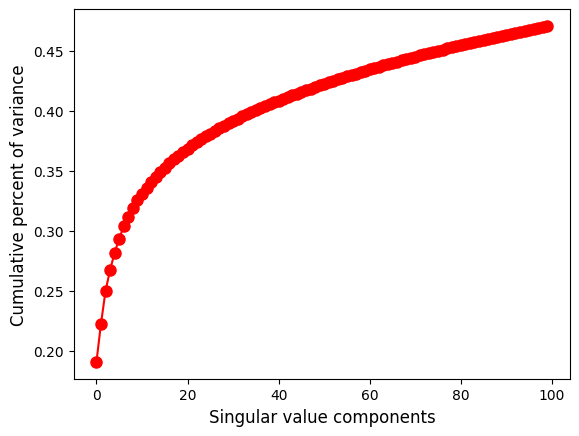

In [23]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()


In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Align the indices of the two latent matrices
common_indices = latent_matrix_1_df.index.intersection(latent_matrix_2_df.index)
latent_matrix_1_df = latent_matrix_1_df.loc[common_indices]
latent_matrix_2_df = latent_matrix_2_df.loc[common_indices]

print(f"Shape of latent_matrix_1_df: {latent_matrix_1_df.shape}")
print(f"Shape of latent_matrix_2_df: {latent_matrix_2_df.shape}")

Shape of latent_matrix_1_df: (26744, 100)
Shape of latent_matrix_2_df: (26744, 100)


In [25]:
# Ensure 'Toy Story (1995)' is in the common indices
if 'Toy Story (1995)' not in common_indices:
    raise ValueError("Toy Story (1995) is not present in both matrices")

# Take the latent vectors for a selected movie from both content and collaborative matrices
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# Calculate the similarity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# Print shapes of the scores
print(f"Shape of score_1: {score_1.shape}")
print(f"Shape of score_2: {score_2.shape}")

Shape of score_1: (26744,)
Shape of score_2: (26744,)


In [26]:
# Verify that the calculated scores have the same shape
assert score_1.shape == score_2.shape, "Calculated scores do not have the same shape"

# An average measure of both content and collaborative
hybrid = ((score_1 + score_2) / 2.0)

# Form a data frame of similar movies
dictDf = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
similar = pd.DataFrame(dictDf, index=latent_matrix_2_df.index)

# Sort it on the basis of either: content, collaborative, or hybrid
# Here: content
similar.sort_values('content', ascending=False, inplace=True)

# Display the top 10 similar movies
similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.981494,0.732942,0.857218
Ratatouille (2007),0.968390,0.414179,0.691285
Finding Nemo (2003),0.966972,0.567972,0.767472
Ice Age (2002),0.964456,0.468390,0.716423
"Bug's Life, A (1998)",0.960187,0.657961,0.809074
Up (2009),0.945147,0.348542,0.646845
"Monsters, Inc. (2001)",0.924463,0.591157,0.757810
Shrek 2 (2004),0.919448,0.514160,0.716804
Toy Story 3 (2010),0.911064,0.394050,0.652557
Shrek (2001),0.894181,0.591785,0.742983


In [27]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.981494,0.732942,0.857218
Willy Wonka & the Chocolate Factory (1971),0.191508,0.668484,0.429996
"Bug's Life, A (1998)",0.960187,0.657961,0.809074
Independence Day (a.k.a. ID4) (1996),0.043358,0.648931,0.346144
Mission: Impossible (1996),0.179467,0.640050,0.409758
Twister (1996),0.177843,0.638992,0.408418
Star Wars: Episode IV - A New Hope (1977),0.064071,0.631876,0.347973
James and the Giant Peach (1996),0.596533,0.619702,0.608117
Groundhog Day (1993),0.227742,0.619533,0.423637
"Lion King, The (1994)",0.745236,0.615317,0.680276


In [28]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.981494,0.732942,0.857218
"Bug's Life, A (1998)",0.960187,0.657961,0.809074
Finding Nemo (2003),0.966972,0.567972,0.767472
"Monsters, Inc. (2001)",0.924463,0.591157,0.757810
Shrek (2001),0.894181,0.591785,0.742983
Shrek 2 (2004),0.919448,0.514160,0.716804
Ice Age (2002),0.964456,0.468390,0.716423
Antz (1998),0.836988,0.569065,0.703026
Chicken Run (2000),0.849663,0.550154,0.699908
"Incredibles, The (2004)",0.855041,0.534438,0.694739


## 3. Hybrid Recommendation System

In [29]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [30]:
recommend_similar_movies("Toy Story (1995)")

                          content  collaborative    hybrid
Toy Story 2 (1999)       0.981494       0.732942  0.857218
Bug's Life, A (1998)     0.960187       0.657961  0.809074
Finding Nemo (2003)      0.966972       0.567972  0.767472
Monsters, Inc. (2001)    0.924463       0.591157  0.757810
Shrek (2001)             0.894181       0.591785  0.742983
Shrek 2 (2004)           0.919448       0.514160  0.716804
Ice Age (2002)           0.964456       0.468390  0.716423
Antz (1998)              0.836988       0.569065  0.703026
Chicken Run (2000)       0.849663       0.550154  0.699908
Incredibles, The (2004)  0.855041       0.534438  0.694739
Ratatouille (2007)       0.968390       0.414179  0.691285


In [31]:
recommend_similar_movies("GoldenEye (1995)")

                                  content  collaborative    hybrid
World Is Not Enough, The (1999)  0.987375       0.645217  0.816296
Tomorrow Never Dies (1997)       0.930991       0.678670  0.804831
Goldfinger (1964)                0.994489       0.539628  0.767058
Licence to Kill (1989)           0.991960       0.540845  0.766402
Die Another Day (2002)           0.994058       0.522066  0.758062
For Your Eyes Only (1981)        0.993602       0.510725  0.752164
View to a Kill, A (1985)         0.987368       0.515665  0.751516
Dr. No (1962)                    0.993306       0.508034  0.750670
Spy Who Loved Me, The (1977)     0.993634       0.503215  0.748425
Live and Let Die (1973)          0.991674       0.503845  0.747760
From Russia with Love (1963)     0.994346       0.499984  0.747165


In [32]:
recommend_similar_movies("Mission: Impossible (1996)")

                                    content  collaborative    hybrid
Rock, The (1996)                   0.683305       0.928745  0.806025
Twister (1996)                     0.691970       0.897975  0.794973
Eraser (1996)                      0.687801       0.824292  0.756047
Speed (1994)                       0.785480       0.719107  0.752294
Mission: Impossible II (2000)      0.840842       0.643595  0.742219
Long Kiss Goodnight, The (1996)    0.775552       0.642100  0.708826
Air Force One (1997)               0.792019       0.613674  0.702846
Mission: Impossible III (2006)     0.946964       0.420488  0.683726
Die Hard: With a Vengeance (1995)  0.722912       0.623735  0.673324
Die Hard (1988)                    0.718659       0.625428  0.672043
True Lies (1994)                   0.667689       0.654054  0.660871


## Surprise

In [33]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [34]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [35]:
movies_metadata

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Watched computer animation Disney animated fea...,Toy Story (1995) Watched computer animation Di...
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel adapted from:book board game child...,Jumanji (1995) time travel adapted from:book b...
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny sequel fever...,Grumpier Old Men (1995) old people that is act...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick flick revenge characters chick flick cha...,Waiting to Exhale (1995) chick flick revenge c...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...,Father of the Bride Part II (1995) Diane Keato...
...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,NaN,Kein Bund für's Leben (2007)
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,NaN,"Feuer, Eis & Dosenbier (2002)"
27275,131258,The Pirates (2014),Adventure,bandits Korea mutiny pirates whale,The Pirates (2014) bandits Korea mutiny pirate...
27276,131260,Rentun Ruusu (2001),(no genres listed),NaN,Rentun Ruusu (2001)


In [36]:
Mapping_file = dict(zip(movies_metadata.title.tolist(), movies_metadata.movieId.tolist()))

In [37]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.7893


0.7893479618588811

In [38]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [40]:
user_id = 19
pred_user_rating(user_id)

,ratings
movies,
Life Is Beautiful (La Vita è bella) (1997),5.000000
Forrest Gump (1994),5.000000
Titanic (1997),4.970525
3 Idiots (2009),4.900148
"Sixth Sense, The (1999)",4.887490
"Sound of Music, The (1965)",4.875169
Braveheart (1995),4.830405
Good Will Hunting (1997),4.827936
Anne of Green Gables: The Sequel (a.k.a. Anne of Avonlea) (1987),4.800826
